In [11]:
import os
os.chdir('/Users/mcha5804/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')
# os.chdir('/Users/mc/Library/CloudStorage/OneDrive-TheUniversityofSydney(Students)/PyCharm/toliman-phd')

import dLux as dl

import jax.scipy as jsp
import matplotlib.pyplot as plt
import dLuxToliman as dlT
import zodiax as zdx
from jax import numpy as np
from jax import Array
import jax
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'magma'
plt.rcParams["font.family"] = "monospace"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'

# Enable 64bit precision (note this must be run in the first cell of the notebook)
jax.config.update("jax_enable_x64", True)

# Creating a jittered instrument
Using new class `dlT.JitteredToliman` 

In [13]:
osys = dlT.TolimanOpticalSystem(
    radial_orders=[2, 3],
    )
osys = osys.divide('aperture.basis', 1e9) # Set basis units to nanometers)

src = dlT.AlphaCen()
no_det_tel = dlT.JitteredToliman(osys=osys, source=src, jitter_mag=20, jitter_angle=135)
tel = no_det_tel.set('detector', dl.LayeredDetector([('Downsample', dl.Downsample(no_det_tel.oversample))]))

Visualising the types of jitter

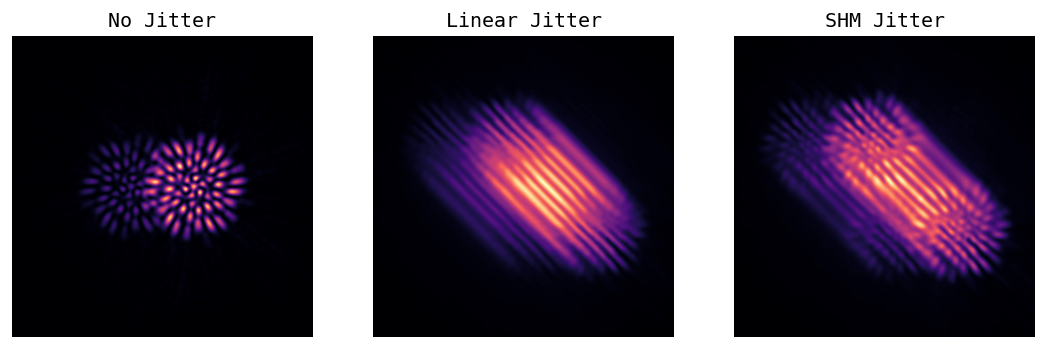

In [5]:
m = no_det_tel.set('n_psfs', 50)
ext = m.psf_pixel_scale * m.psf_npixels /2
ext = [-ext, ext, -ext, ext]
fig, ax = plt.subplots(1, 3, figsize=(11, 4))
ax[0].imshow(m.model(), extent=ext)
ax[0].set(
    title='No Jitter',
    xlabel='x [arcsec]',
    ylabel='y [arcsec]',
)
ax[0].axis('off')
ax[1].imshow(m.jitter_model(), extent=ext)
ax[1].set(
    title='Linear Jitter',
    xlabel='x [arcsec]',
    ylabel='y [arcsec]',
)
ax[1].axis('off')
ax[2].imshow(m.set('jitter_shape', 'shm').jitter_model(), extent=ext)
ax[2].set(
    title='SHM Jitter',
    xlabel='x [arcsec]',
    ylabel='y [arcsec]',
)
ax[2].axis('off')
# plt.savefig('figs/3jit_diag.pdf', dpi=500, bbox_inches='tight')
plt.show()

In [5]:
loglike_fn = lambda pytree, data: jsp.stats.poisson.logpmf(pytree.jitter_model(), data).sum()

calc_cov = lambda model, parameters: -np.linalg.inv(
    zdx.fisher_matrix(
        model, 
        parameters,
        loglike_fn,
        model.jitter_model(),
        shape_dict={'wavelengths': 1},
        )
    )
cov_fn = zdx.filter_jit(calc_cov)  # jitting

In [8]:
# Marginal parameters
params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
    'wavelengths',
    'psf_pixel_scale',  
    'jitter_mag',
    'jitter_angle',
    'aperture.coefficients',
]

det_pscale = tel.psf_pixel_scale

mags = np.linspace(1e-4, 2*det_pscale, 10)
angs = np.linspace(0, 90, 3)
shapes = [
    "linear",
    "shm",
    ]


In [6]:
seps_lin = []; seps_shm = []
nan_flag = False
for mag_idx, mag in tqdm(enumerate(mags), total=len(mags)):
    model = tel.set("jitter_mag", mag)

    for ang_idx, ang in enumerate(angs):        
        model = model.set("jitter_angle", ang)

        for shape in shapes:
            model = model.set("jitter_shape", shape)
            cov = cov_fn(model, params)
            sep = np.sqrt(np.abs(cov[0, 0]))

            if shape == "linear":
                seps_lin.append(sep)
            elif shape == "shm":
                seps_shm.append(sep)

            if np.isnan(sep).any():
                print(f"NaNs found at mag_idx={mag_idx}, ang_idx={ang_idx}, shape={shape}")
                nan_flag = True
                break  # break out of inner loop
        if nan_flag: break
    if nan_flag: break

if not nan_flag:
    if "linear" in shapes:
        seps_lin = np.array(seps_lin).reshape(len(mags), len(angs))
    if "shm" in shapes:
        seps_shm = np.array(seps_shm).reshape(len(mags), len(angs))

  0%|          | 0/10 [00:00<?, ?it/s]

NameError: name 'cov_fn' is not defined

In [9]:
# np.save("data/seps_lin.npy", seps_lin)
# np.save("data/seps_shm.npy", seps_shm)

In [6]:
seps_lin = np.load("data/seps_lin.npy")
seps_shm = np.load("data/seps_shm.npy")

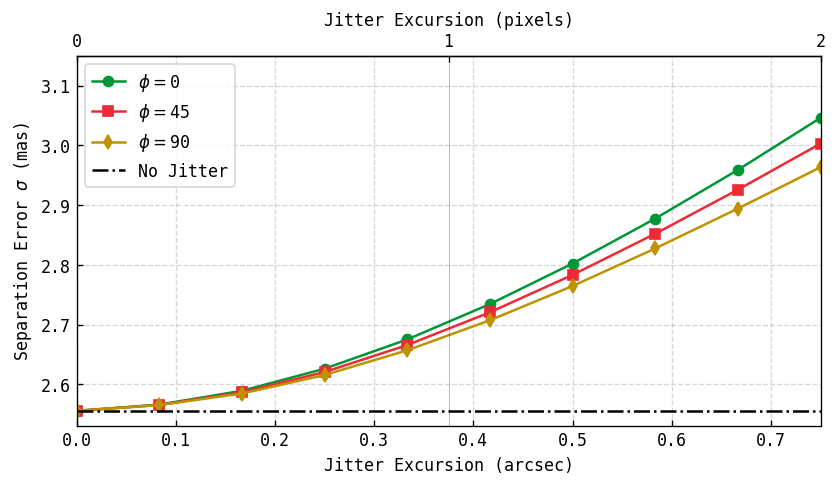

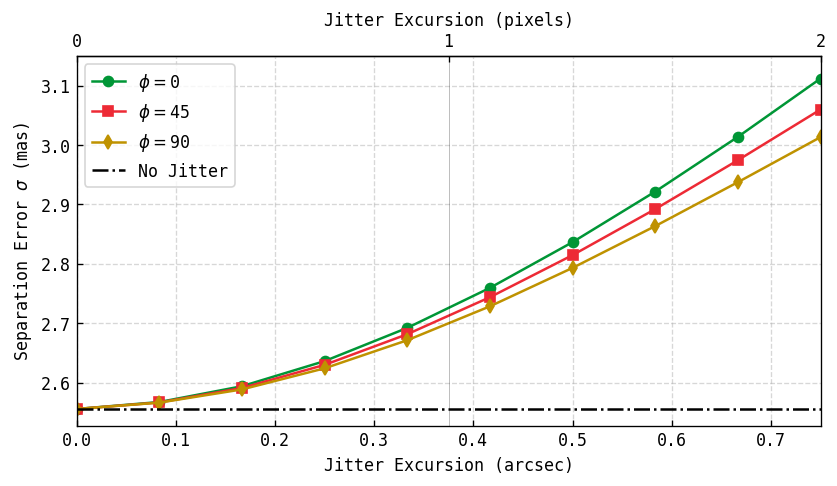

In [10]:
def plot_seps(seps, title=None):
    fig, ax = plt.subplots(figsize=(8, 4))

    colors = [(0, 151/256, 54/256), (238/256, 42/256, 53/256), (192/256, 147/256, 0)]
    markers = ['o', 's', 'd']

    for sep, ang, c, m in zip(seps.T, angs, colors, markers):
        ax.plot(mags, 1000 * sep, label=r"$\phi=$" +f"{ang:.0f}", color=c, marker=m)

    # baseline
    ax.axhline(2.5556666339644867, linestyle='-.', c='k', label='No Jitter')

    ax.set(
        xlabel='Jitter Excursion (arcsec)',
        ylabel=r'Separation Error $\sigma$ (mas)',
        xlim=(0, mags.max()),
        ylim=(None, 3.15),
        # title=f"Fisher Analysis of {title} Jitter",
    )

    # Add secondary x-axis scale showing units of pixels
    ax2 = ax.secondary_xaxis('top', functions=(lambda x: x/det_pscale, lambda x: x*det_pscale))
    ax2.set(
        xlabel='Jitter Excursion (pixels)',
        xticks=[0, 1., 2.]
        )
    ax.axvline(x=det_pscale, linestyle='-', color='k', alpha=0.3, linewidth=0.5)

    ax.tick_params(direction='in')
    ax2.tick_params(direction='in')
    ax.legend()
    ax.grid(True, alpha=0.5, linestyle='--')

    # plt.savefig(f"figs/{title}_results.pdf", dpi=500, bbox_inches='tight')
    plt.show()

plot_seps(np.array(seps_lin), "Linear")
plot_seps(np.array(seps_shm), "Simple Harmonic")

In [11]:
truth = tel.set(["n_psfs", "jitter_mag"], [100, mags.max()]).jitter_model()

resids = []
n_psfses = [2, 3, 4, 5, 6, 8, 10, 20]
for n_psfs in n_psfses:
    test_case = tel.set("n_psfs", n_psfs).jitter_model()
    resids.append(np.sum(np.abs(test_case - truth)))

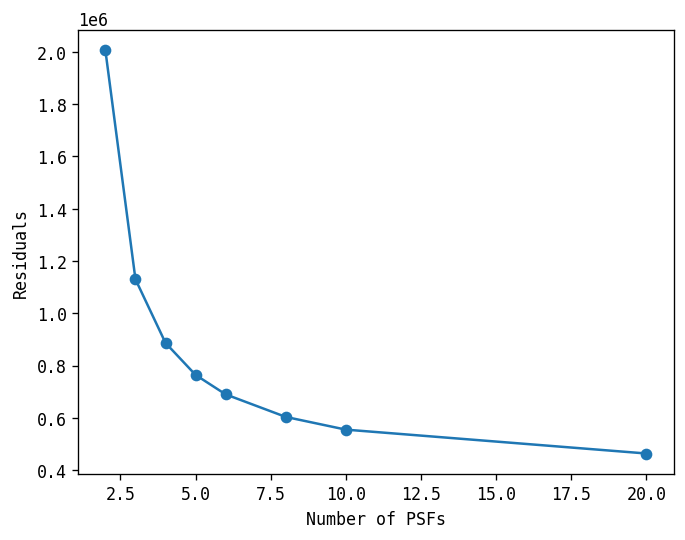

In [35]:
plt.plot(n_psfses, resids, marker='o')
plt.xlabel("Number of PSFs")
plt.ylabel("Residuals")
plt.show()

In [25]:
# Finding baseline covariance
bl_loglike_fn = lambda pytree, data: jsp.stats.poisson.logpmf(pytree.model(), data).sum()

bl_calc_cov = lambda model, parameters: -np.linalg.inv(
    zdx.fisher_matrix(
        model, 
        parameters,
        bl_loglike_fn,
        model.model(),
        shape_dict={'wavelengths': 1},
        )
    )
bl_cov_fn = zdx.filter_jit(bl_calc_cov)  # jitting


In [27]:
bl_params = [
    'separation',
    'position_angle',
    'x_position',
    'y_position',
    'log_flux',
    'contrast',
    'wavelengths',
    'psf_pixel_scale',  
    'aperture.coefficients',
]

cov = bl_cov_fn(tel, bl_params)
sep = np.sqrt(np.abs(cov[0, 0]))
print(1e3*sep)

2.5556666339644867


Array(0.75, dtype=float64)